In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

In [2]:
from sklearn.metrics import mean_absolute_error, auc, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Load the training and test data

In [3]:
df_train_orig = pd.read_csv("data/train_v2.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (135,204,274,417) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_test = pd.read_csv("data/test_v2.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (417) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Identify the feature columns and clean and preprocess the data

In [5]:
feature_cols = [c for c in df_train_orig.columns if c.startswith("f")]

In [6]:
def clean_up_column(x):
    if type(x) == float or type(x) == int:
        return x
    return 0


In [7]:
def preprocess_clean_dataframe(df):
    for c in feature_cols:
        df[c] = df[c].apply(clean_up_column)  
    df.fillna(0, inplace=True)
    return df

In [8]:
df_train_orig = preprocess_clean_dataframe(df_train_orig)
df_test = preprocess_clean_dataframe(df_test)

# Split off a small eval set

In [9]:
df_train, df_eval = train_test_split(df_train_orig, test_size=0.1, random_state=42)

# Make upsampled train DF to cover for fact that most clients don't default

In [10]:
nonzero_cases = df_train[df_train.loss > 0]

to_concatenate = [df_train]
for i in range(10):
    to_concatenate.append(nonzero_cases)


df_train_upsampled = pd.concat(to_concatenate).sample(frac=1) # shuffle

In [11]:
y_train = df_train["loss"]

In [12]:
y_eval = df_eval["loss"]

# Make pipeline of preprocessors + models

Model consists of:

* robust scaler
* PCA to 50 dimensions
* RandomForestClasssifier with 100 estimators to predict if default
* RandomForestRegressor with 100 estimators to predict default value

In [13]:
# Function to convert the regression problem into a classification problem
def binariser(x):
    return int(x > 0)

In [14]:
classifier_scaler = RobustScaler()

In [15]:
classifier_pca = PCA(n_components=50)

In [16]:
classifier_model = RandomForestClassifier(n_estimators=100)

In [17]:
classifier_pipeline = make_pipeline(classifier_scaler, classifier_pca, classifier_model)

In [18]:
regressor_scaler = RobustScaler()

In [19]:
regressor_pca = PCA(n_components=50)

In [20]:
regressor_model = RandomForestRegressor(n_estimators=100)

In [21]:
regressor_pipeline = make_pipeline(regressor_scaler, regressor_pca, regressor_model)

In [22]:
classifier_pipeline.fit(df_train_upsampled[feature_cols], df_train_upsampled["loss"].apply(binariser))

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassif...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [23]:
y_eval_pred = classifier_pipeline.predict(df_eval[feature_cols])

In [24]:
y_eval_is_default = pd.Series(y_eval_pred).apply(binariser)

In [25]:
y_eval_pred_is_default = classifier_pipeline.predict(df_eval[feature_cols])

In [26]:
y_eval_pred_is_default_proba = classifier_pipeline.predict_proba(df_eval[feature_cols])

In [27]:
confusion_matrix(y_eval_is_default, y_eval_pred_is_default)

array([[10543,     0],
       [    0,     5]])

AUC is 1.0


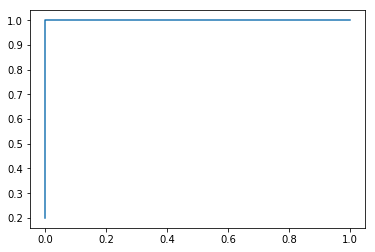

In [28]:
fpr, tpr, thresholds = roc_curve(y_eval_is_default, y_eval_pred_is_default_proba[:,1])

plt.plot(fpr, tpr)
print ("AUC is", auc(fpr, tpr))

# Train the regressor on the defaulted cases only

In [29]:
df_train_defaulted = df_train[df_train.loss > 0]

In [30]:
regressor_pipeline.fit(df_train_defaulted[feature_cols], df_train_defaulted["loss"])

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('randomforestregressor', RandomForestRegresso...imators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

# Get the prediction

In [31]:
y_eval_pred_second_half = regressor_pipeline.predict(df_eval[feature_cols]) * y_eval_pred_is_default

In [32]:
mean_absolute_error(y_eval, y_eval_pred_second_half)

0.7947174819871066

# Try making test set prediction

Note that I am doing something very inefficient here: I am calculating the regression value for all users, and multiplying it by 0 for the 90% of users who were not predicted to default! It would run 10x faster if this inefficiency were to be removed.

In [33]:
y_test_pred_is_default = classifier_pipeline.predict(df_test[feature_cols])

In [34]:
y_test_pred_second_half = regressor_pipeline.predict(df_test[feature_cols]) * y_test_pred_is_default

In [35]:
df_test_submission = pd.DataFrame()
df_test_submission["id"] = df_test["id"]
df_test_submission["loss"] = y_test_pred_second_half


In [36]:
df_test_submission.head()

,id,loss
0,105472,0.0
1,105473,0.0
2,105474,0.0
3,105475,0.0
4,105476,0.0


In [37]:
df_test_submission.to_csv("submission2.csv",index=False)